In [30]:
import json
import pandas as pd
import os

df = pd.DataFrame()
for dirname, _, filenames in os.walk('../data/27/'):
    for filename in filenames:
        data = {}
        with open(os.path.join(dirname, filename),'r') as file:
            d = json.loads(file.read())
        data['date'] = d['Indices']['NDVI']['Serie Processada']['Data']
        data['indices'] = d['Indices']['NDVI']['Serie Processada']['Indice']
        part = pd.DataFrame(data)
        part['date'] = pd.to_datetime(part['date'], format='%Y-%m-%d')
        print(os.path.join(dirname, filename))
        df = pd.concat([df, part])
df.head(10)

../data/27/2014-2015.json
../data/27/2016-2017.json
../data/27/2018-2019.json
../data/27/2015-2016.json
../data/27/2017-2018.json


,date,indices
0,2014-07-04,0.515106
1,2014-07-12,0.456973
2,2014-07-20,0.395650
3,2014-07-28,0.359355
4,2014-08-05,0.345079
5,2014-08-13,0.338564
6,2014-08-21,0.328624
7,2014-08-29,0.313193
8,2014-09-06,0.297851
9,2014-09-14,0.289836


In [31]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.set_index('date')
df = df.groupby(df.index).mean()
df = df.asfreq("W",method='backfill')
df = df.sort_index()
df.head(10)

,indices
date,
2014-07-06,0.456973
2014-07-13,0.395650
2014-07-20,0.395650
2014-07-27,0.359355
2014-08-03,0.345079
2014-08-10,0.338564
2014-08-17,0.328624
2014-08-24,0.313193
2014-08-31,0.297851


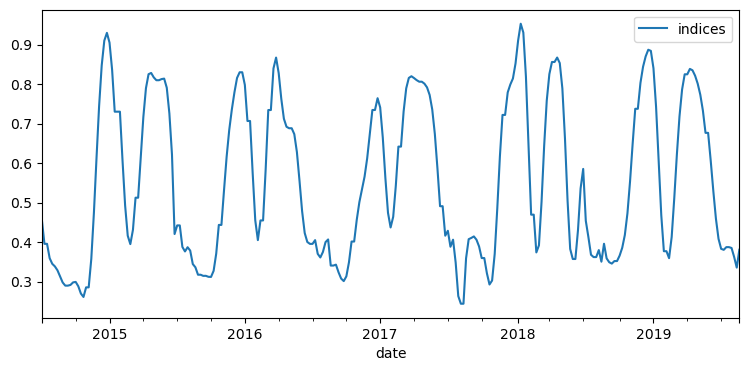

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9, 4))
df['indices'].plot(ax=ax, label='indices')
ax.legend()

In [33]:
from datetime import datetime

steps=10
X_train = df.loc[:datetime.strptime('2019-02-20', "%Y-%m-%d")]
X_test = df.loc[datetime.strptime('2019-02-20', "%Y-%m-%d"):datetime.strptime('2019-05-30', "%Y-%m-%d")]

In [34]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
auto = auto_arima(
    X_train['indices'],
    seasonal=True,
    stationary=True,
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-813.047, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-90.177, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-660.135, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-367.447, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=428.198, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-782.750, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-814.448, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-752.407, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-813.863, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-812.745, Time=0.27 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-814.703, Time=0.16 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-812.787, Time=0.14 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-810.706, Time=0.19 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-785.148, Time=0.02 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0

In [35]:
sarima = SARIMAX(X_train['indices'],order=auto.order,seasonal_order=(1,2,1,8),freq='W',enforce_stationarity=True)
model = sarima.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.01273D-01    |proj g|=  2.87604D+00

At iterate    5    f= -9.48281D-01    |proj g|=  1.95900D+00

At iterate   10    f= -1.10916D+00    |proj g|=  3.90690D-01

At iterate   15    f= -1.12981D+00    |proj g|=  2.26707D+00

At iterate   20    f= -1.27781D+00    |proj g|=  8.40638D-01

At iterate   25    f= -1.27965D+00    |proj g|=  3.17427D-01

At iterate   30    f= -1.28628D+00    |proj g|=  9.16346D-02

At iterate   35    f= -1.28644D+00    |proj g|=  2.48775D-02

At iterate   40    f= -1.28756D+00    |proj g|=  5.51161D-02

At iterate   45    f= -1.28866D+00    |proj g|=  8.31080D-03

At iterate   50    f= -1.29025D+00    |proj g|=  4.52844D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number

/home/pedro/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [36]:
forecast = model.get_forecast(steps=len(X_test))
print(type(forecast))
forecast = pd.DataFrame(forecast.predicted_mean)
forecast.head(10)

<class 'statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper'>


,predicted_mean
2019-02-24,0.389398
2019-03-03,0.431789
2019-03-10,0.460126
2019-03-17,0.434078
2019-03-24,0.445901
2019-03-31,0.471640
2019-04-07,0.537279
2019-04-14,0.581778
2019-04-21,0.632461
2019-04-28,0.661627


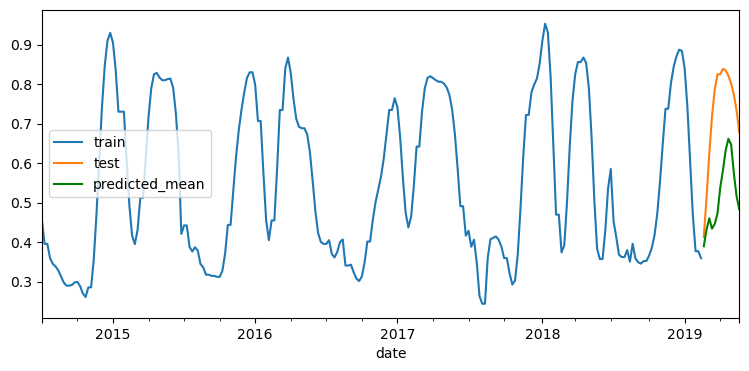

In [37]:
fig, ax=plt.subplots(figsize=(9, 4))
X_train['indices'].plot(ax=ax, label='train')
X_test['indices'].plot(ax=ax, label='test')
forecast.plot(ax=ax, label='predictions', color='green')
ax.legend()

In [38]:
import joblib

joblib.dump(model,'../model/27.h5')

['../model/27.h5']